In [1]:
import pandas as pd
import missingno as msno

import numpy as np

0 - Nettoyage du dataset

In [2]:
#Réccuperation du dataframe
original_dataframe = pd.read_csv("fr.openfoodfacts.org.products.csv", sep="\t")
df = original_dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#suppression des colonnes ne contenant que des NaN
df_sans_nan = df.drop(columns=df.columns[df.isna().all()])

#suppression des colonnes avec des valeurs manquantes au niveau du nutriscore et nutrition grade
df_sans_nan = df_sans_nan.dropna(subset=['nutrition_grade_fr', 'nutrition-score-fr_100g'])

# Identifier les colonnes où le pourcentage de NaN dépasse le seuil
seuil = 0.95
colonnes_trop_nan = df_sans_nan.columns[df_sans_nan.isna().mean() > seuil]

#Trier dataset par nutrigrade de A à E
df_sorted_by_ng = df_sans_nan.sort_values(by='nutrition_grade_fr', ascending=True)
#suppression des outliers des colonnes pertinentes pour les analyses
print(df.shape)
df_sorted_by_ng.head()

C:\Users\p2972\AppData\Local\Temp\ipykernel_12596\3156980001.py:2: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  original_dataframe = pd.read_csv("fr.openfoodfacts.org.products.csv", sep="\t")


(320772, 162)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,montanic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,gondoic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
255333,3770002327272,http://world-fr.openfoodfacts.org/produit/3770...,tacite,1423745415,2015-02-12T12:50:15Z,1426503594,2015-03-16T10:59:54Z,Brocoli,NaN,120 g,"Gourde,Plastique","gourde,plastique",Good Goût,good-gout,"Aliments pour bébé,Dès 4 mois","en:baby-foods,en:from-4-months","Aliments pour bébé,Dès 4 mois",NaN,NaN,France,france,"Bio,Bio européen,Sans gluten,AB Agriculture Bi...","en:organic,en:eu-organic,en:gluten-free,fr:ab-...","Bio,Bio européen,Sans gluten,AB Agriculture Bi...",NaN,NaN,NaN,NaN,NaN,"Noyelles-Godault,France",Auchan,France,en:france,France,"80% brocoli bio, eau.",NaN,NaN,NaN,NaN,NaN,120 g,0.0,[ 80-brocoli-bio -> fr:80-brocoli-bio ] [ 8...,NaN,NaN,0.0,NaN,0.0,NaN,a,unknown,unknown,"en:to-be-checked, en:complete, en:nutrition-fa...","en:to-be-checked,en:complete,en:nutrition-fact...","A vérifier,Complet,Informations nutritionnelle...",en:baby-foods,Aliments pour bébé,http://fr.openfoodfacts.org/images/products/37...,http://fr.openfoodfacts.org/images/products/37...,96.0,NaN,0.40,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.30,1.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,1.70,NaN,NaN,NaN,0.109982,0.0433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.0,-3.0
88587,75391050347,http://world-fr.openfoodfacts.org/produit/0075...,usda-ndb-import,1489090930,2017-03-09T20:22:10Z,1489090930,2017-03-09T20:22:10Z,Raw Sea Scallops,NaN,NaN,NaN,NaN,Beaver Street Fisheries,beaver-street-fisheries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,Scallops,Na

<Axes: >

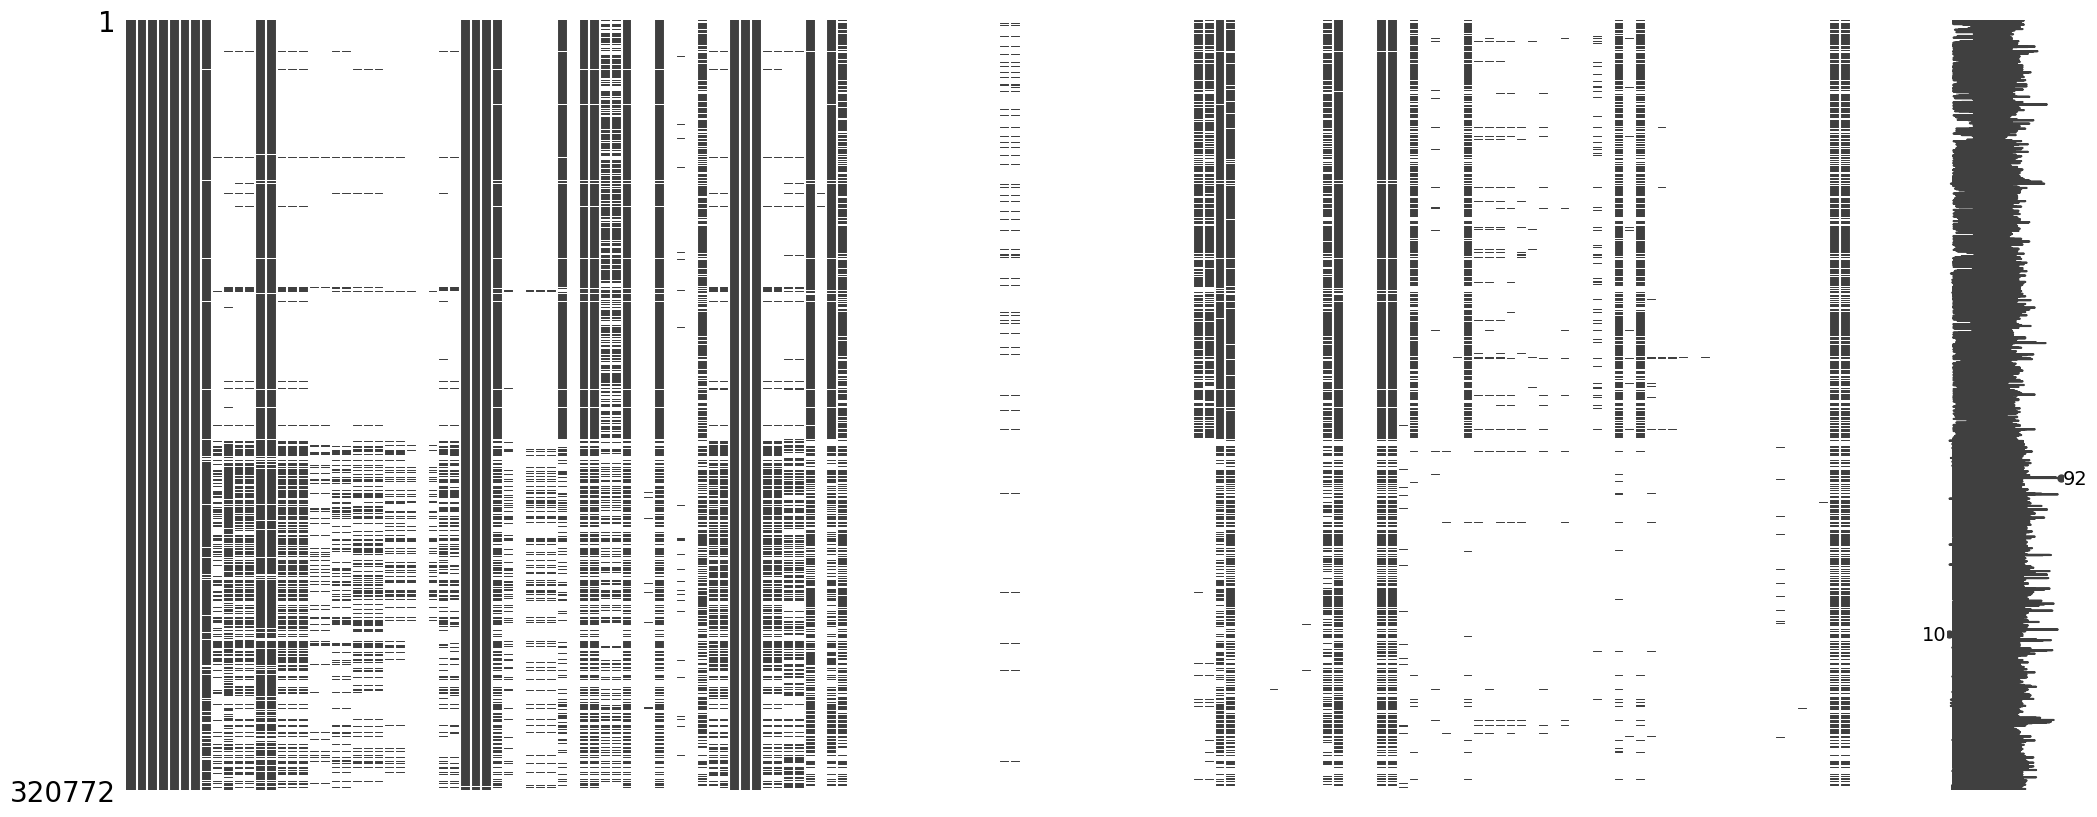

In [3]:
#dataframe brut fourni par openfoodfacts
msno.matrix(df)

<Axes: >

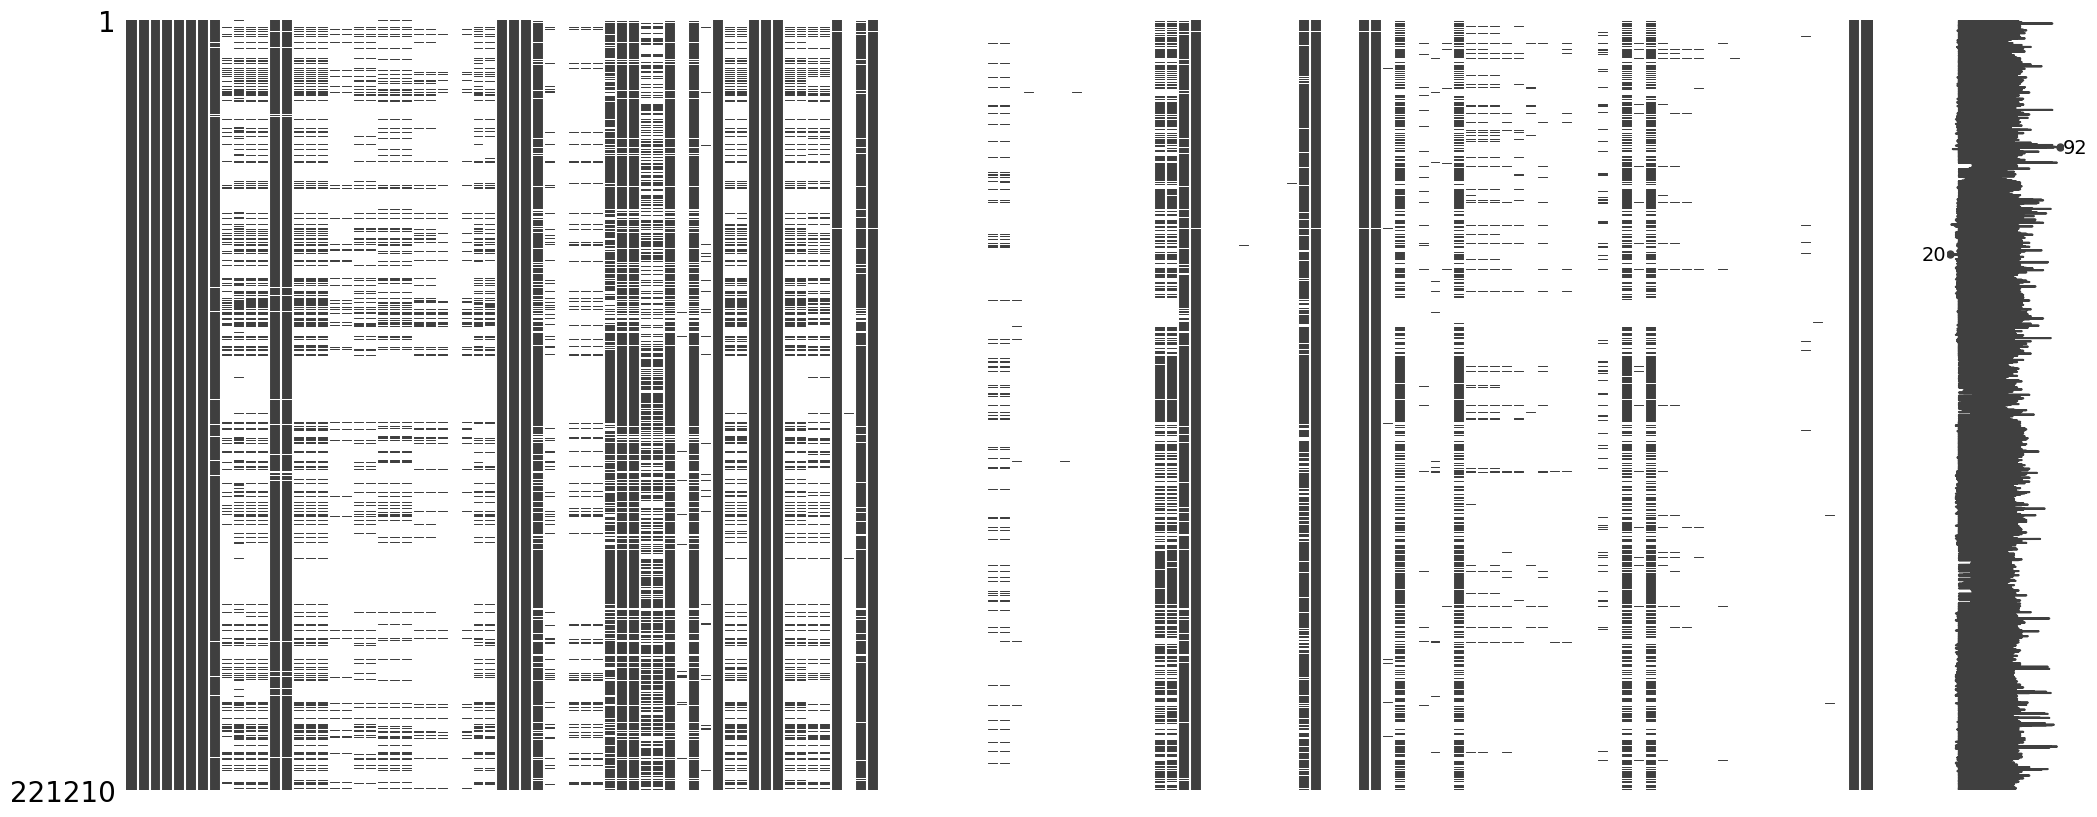

In [4]:
#dataframe sans les collones nan et nan a plus de 95 %
msno.matrix(df_sorted_by_ng)

2 - Préparation du dataset

In [5]:
#Trier dataset par nutrigrade de A à E
df_sorted_by_ng = df_sans_nan.sort_values(by='nutrition_grade_fr', ascending=True)
"""Les colonnes pertinantes pour l'analyse sont:
- fat_100g
- saturated-fat_100g
- monounsaturated-fat_100g
- polyunsaturated-fat_100g
- sugars_100g
- fiber_100g
- proteins_100g
- salt_100g
- sodium_100g
"""
#suppression des outliers des colonnes pertinentes pour les analyses
df_sans_outliers_analyse = df_sorted_by_ng
#Fonction pour supprimer les outliers
def delete_outliers(dataset, column):
    col = dataset[column]
    # Calcul des bornes en ignorant les NaN
    Q1 = np.nanpercentile(col, 25)
    Q3 = np.nanpercentile(col, 75)
    EIQ = Q3 - Q1
    lower_bound = max(Q1 - 1.5 * EIQ, 0)
    upper_bound = Q3 + 1.5 * EIQ

    # Création du masque
    # On garde les NaN et les valeurs comprises entre lower_bound et upper_bound
    mask = col.isna() | ((col >= lower_bound) & (col <= upper_bound))
    return dataset[mask]


#pour chaque colonnes supprimer les outliers et stocker le dataset modifié 
df_sans_outliers_analyse =  delete_outliers(df_sans_outliers_analyse, 'fat_100g')
df_sans_outliers_analyse =  delete_outliers(df_sans_outliers_analyse, 'saturated-fat_100g')
df_sans_outliers_analyse =  delete_outliers(df_sans_outliers_analyse, 'monounsaturated-fat_100g')
df_sans_outliers_analyse =  delete_outliers(df_sans_outliers_analyse, 'polyunsaturated-fat_100g')
df_sans_outliers_analyse =  delete_outliers(df_sans_outliers_analyse, 'sugars_100g')
df_sans_outliers_analyse =  delete_outliers(df_sans_outliers_analyse, 'fiber_100g')
df_sans_outliers_analyse =  delete_outliers(df_sans_outliers_analyse, 'proteins_100g')
df_sans_outliers_analyse =  delete_outliers(df_sans_outliers_analyse, 'salt_100g')
df_sans_outliers_analyse =  delete_outliers(df_sans_outliers_analyse, 'sodium_100g')
df_sans_outliers_analyse.shape

(155185, 146)

<Axes: >

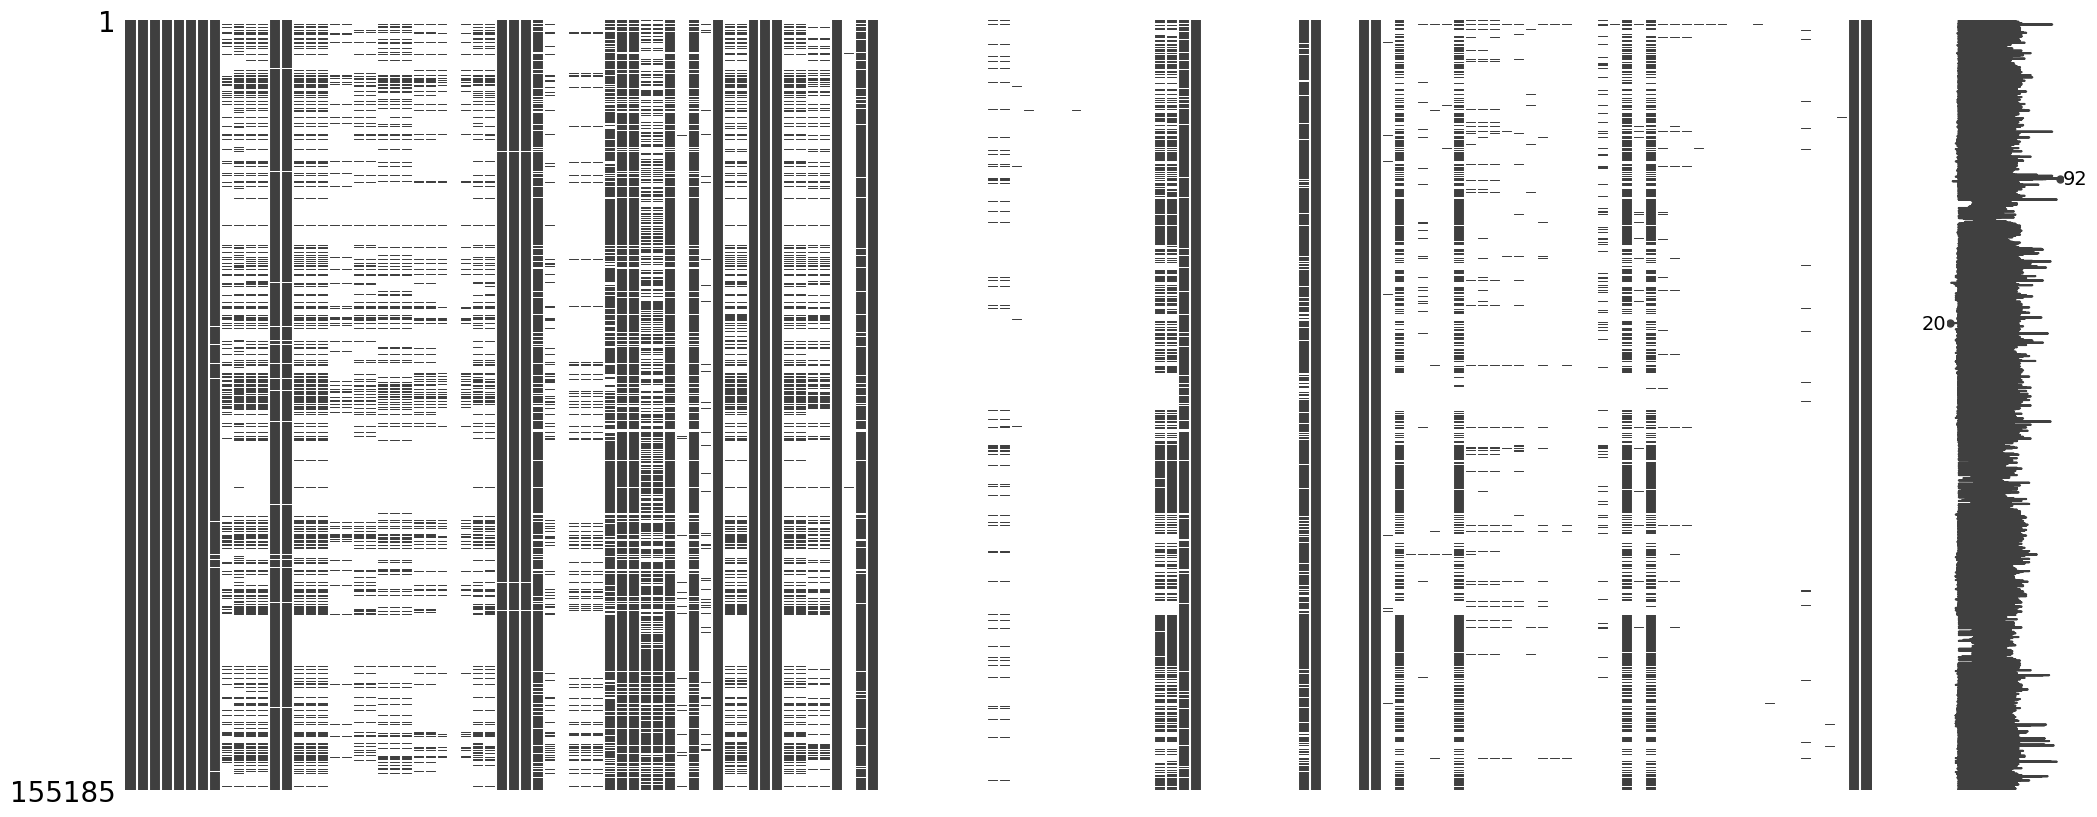

In [6]:
msno.matrix(df_sans_outliers_analyse)

1 - Qu'est-ce qui caractérise un aliment saint

In [7]:
#Nouveau dataframe avec uniquement les colonnes pertinantes pour répondre à la question
df_aliment_saint = df_sans_outliers_analyse[['product_name', 'nutrition_grade_fr', 'nutrition-score-fr_100g', 'energy_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g','trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'salt_100g', 'sodium_100g','additives_n', 'ingredients_text','vitamin-a_100g', 'vitamin-c_100g', 'potassium_100g', 'calcium_100g', 'iron_100g',  'fiber_100g', 'proteins_100g']]
df_aliment_saint_full = df_sans_outliers_analyse
#vérification de la présence d'outliers

df_aliment_saint_full.shape
df_aliment_saint.describe()

,nutrition-score-fr_100g,energy_100g,sugars_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,salt_100g,sodium_100g,additives_n,vitamin-a_100g,vitamin-c_100g,potassium_100g,calcium_100g,iron_100g,fiber_100g,proteins_100g
count,155185.000000,154994.000000,154994.00000,142809.000000,154994.000000,12509.000000,12528.000000,92352.000000,93765.000000,142840.000000,154994.000000,154994.000000,137227.000000,90732.000000,91784.000000,15996.000000,93256.000000,92403.000000,136616.000000,154994.000000
mean,6.832993,957.484599,11.46179,9.195982,3.153834,3.209556,1.910874,0.070681,0.016022,30.124143,0.742281,0.292237,2.127810,0.000135,0.009007,0.219711,0.073335,0.002248,1.953648,6.142408
std,8.440667,850.740045,13.60918,10.654376,4.226416,4.012318,2.220527,1.770439,0.236706,26.266167,0.699755,0.275494,2.630436,0.002746,0.524931,0.472097,1.304652,0.091517,2.121229,5.392512
min,-14.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-3.570000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000260,0.000000,0.000000
25%,0.000000,326.000000,1.60000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,7.140000,0.101600,0.040000,0.000000,0.000000,0.000000,0.106000,0.000000,0.000000,0.000000,1.670000
50%,5.000000,840.000000,4.90000,4.620000,1.160000,1.590000,1.160000,0.000000,0.000000,19.595000,0.612140,0.241000,1.000000,0.000000,0.000000,0.163000,0.032000,0.000890,1.400000,4.900000
75%,13.000000,1531.000000,17.75000,15.220000,5.000000,5.290000,3.100000,0.000000,0.018000,53.570000,1.181100,0.465000,3.000000,0.000102,0.004000,0.240000,0.091000,0.002060,3.200000,9.090000
max,36.000000,182764.000000,52.63000,52.220000,17.100000,17.800000,9.300000,369.000000,70.588000,209.380000,2.860000,1.121000,31.000000,0.800000,152.941200,38.333000,285.714000,25.000000,9.000000,22.220000


In [8]:
# ancienne dataframe avec valeures abérantes
df_sans_nan[[ 'sugars_100g', 'fat_100g', 'saturated-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g' , 'sodium_100g',  'fiber_100g', 'proteins_100g']].describe()

,sugars_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,sodium_100g,fiber_100g,proteins_100g
count,221019.000000,203733.000000,221019.000000,20151.000000,20179.000000,221019.000000,193770.000000,221019.000000
mean,15.023803,13.367035,4.970118,7.235400,4.988618,0.645805,2.828862,7.775905
std,21.181012,16.208529,7.659902,11.930241,8.325063,54.100789,13.016507,8.123994
min,-17.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.570000
25%,1.300000,0.880000,0.000000,0.000000,0.000000,0.039370,0.000000,1.900000
50%,5.000000,7.140000,1.790000,3.330000,1.790000,0.255906,1.500000,5.700000
75%,23.080000,21.430000,7.140000,8.930000,6.060000,0.536000,3.600000,10.710000
max,3520.000000,714.290000,550.000000,557.140000,75.000000,25320.000000,5380.000000,430.000000


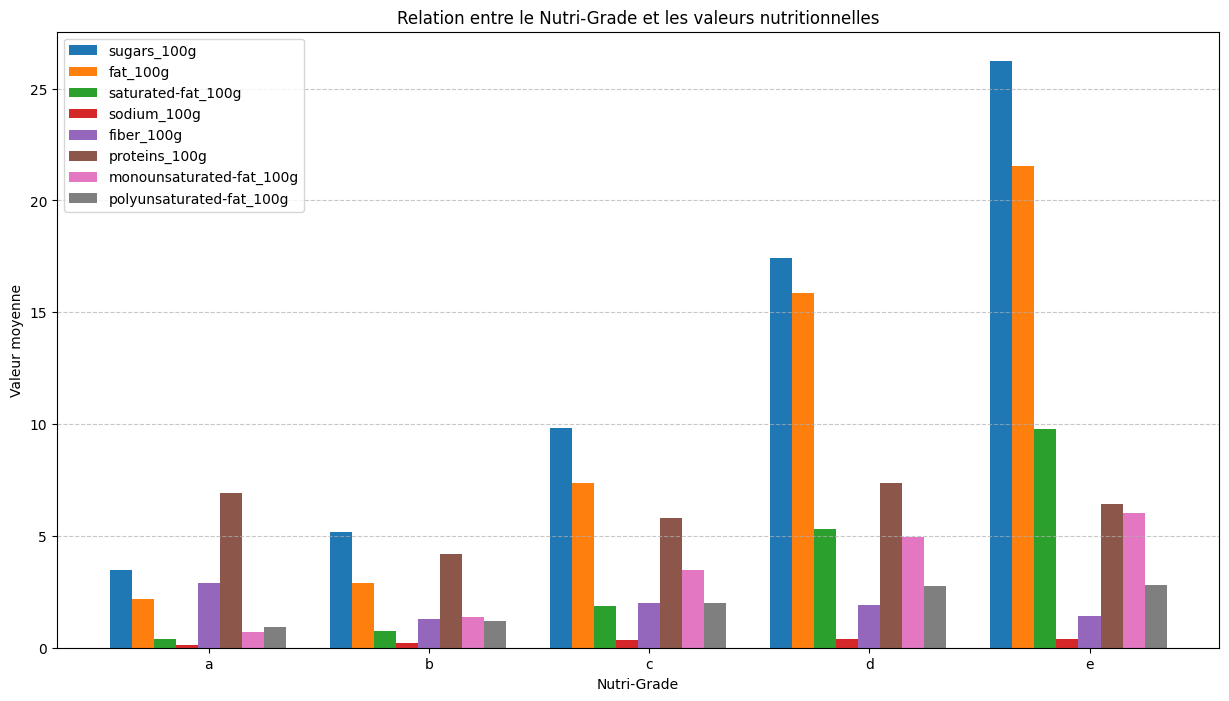

In [9]:
import matplotlib.pyplot as plt
# Colonnes pertinentes pour l'analyse
columns_of_interest = [
    'sugars_100g', 'fat_100g', 'saturated-fat_100g',
    'sodium_100g','fiber_100g', 'proteins_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g'
]
# Calculer les moyennes par Nutri-Score
mean_values = df_aliment_saint.groupby('nutrition_grade_fr')[columns_of_interest].mean()

# Paramètres pour le barplot groupé
bar_width = 0.1
x = np.arange(len(mean_values.index))  # Position des Nutri-Scores sur l'axe X

plt.figure(figsize=(15, 8))

# Tracer les barres pour chaque élément nutritionnel
for i, column in enumerate(columns_of_interest):
    plt.bar(
        x + i * bar_width,
        mean_values[column],
        width=bar_width,
        label=column
    )

# Ajouter des labels et une légende
plt.title('Relation entre le Nutri-Grade et les valeurs nutritionnelles')
plt.xlabel('Nutri-Grade')
plt.ylabel('Valeur moyenne')
plt.xticks(x + bar_width * (len(columns_of_interest) / 2), mean_values.index)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<Axes: >

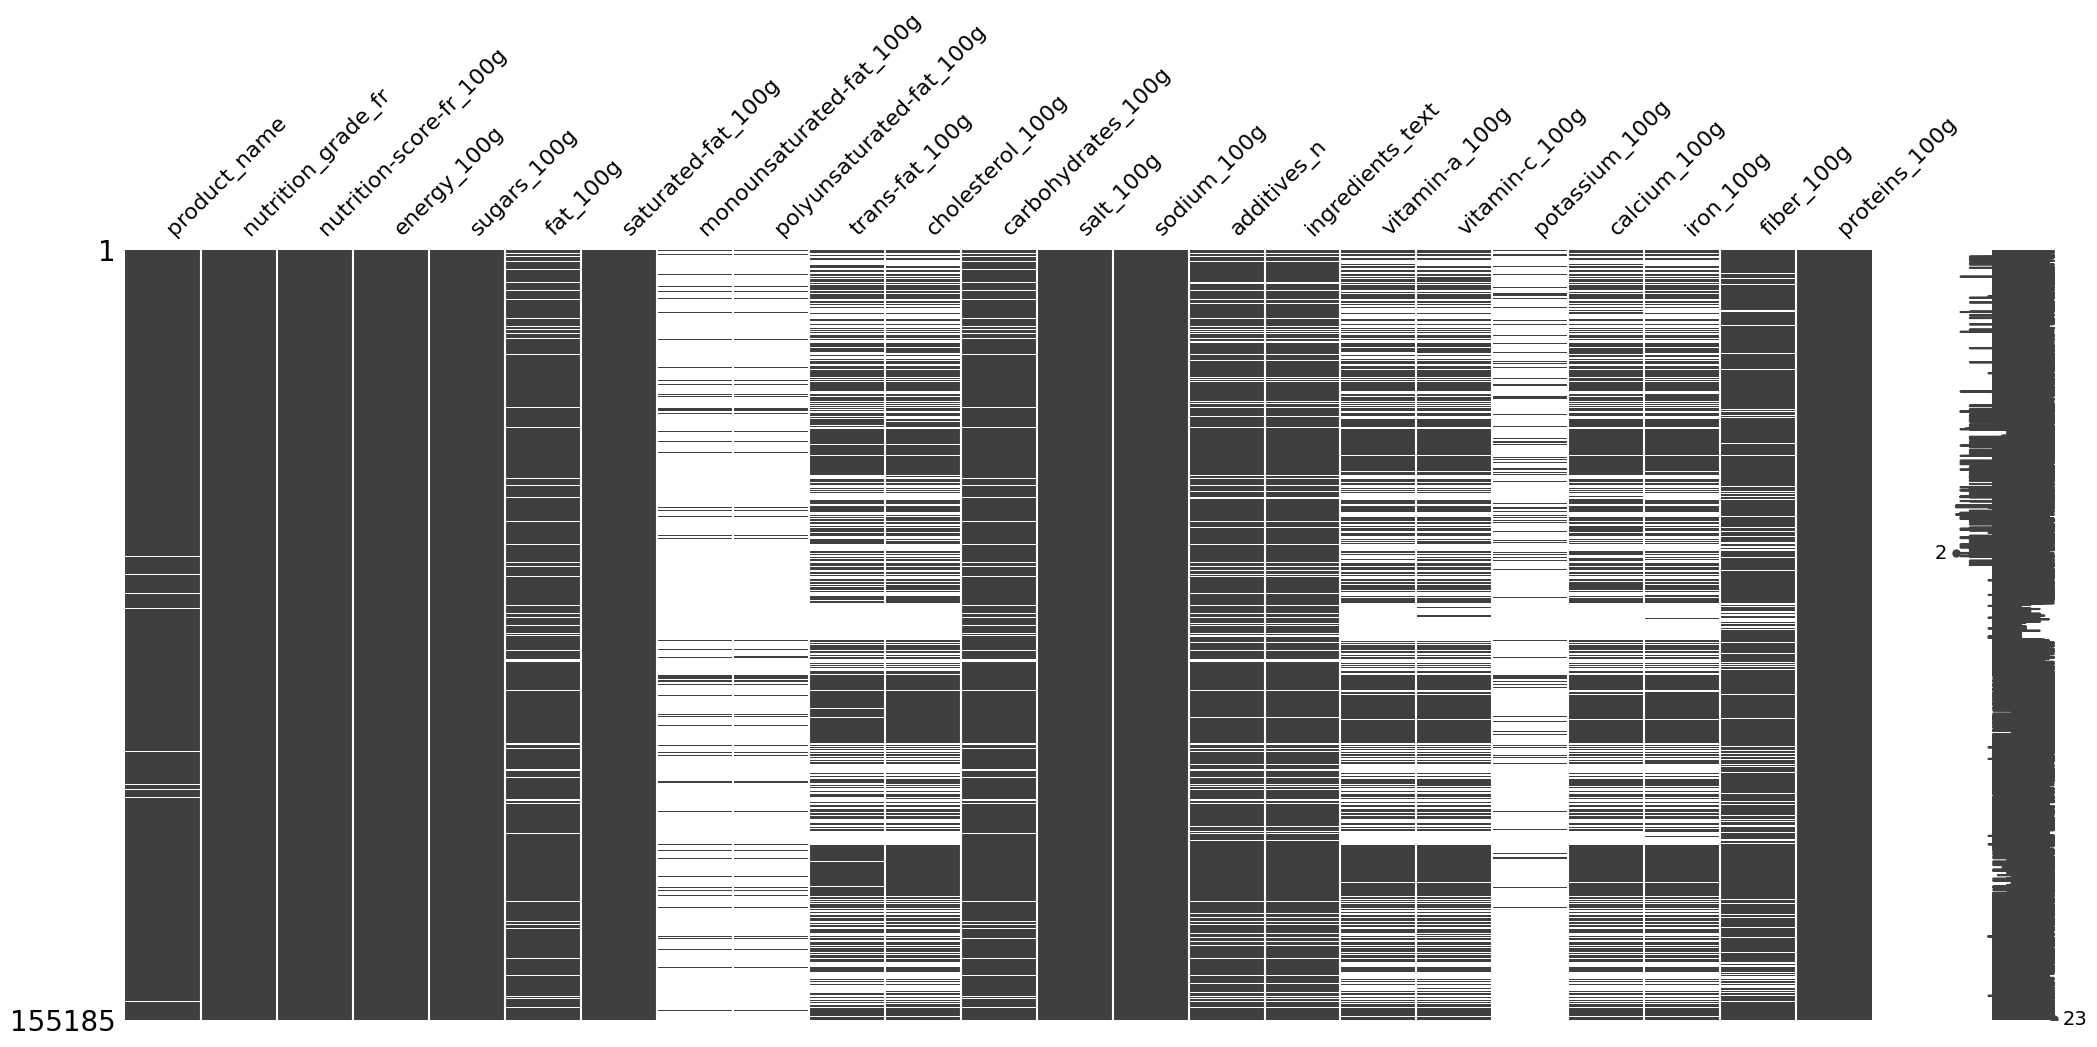

In [10]:
#df préparé pour le graphique ci dessus
msno.matrix(df_aliment_saint)

In [11]:


columns_of_interest_for_corr = [
    'nutrition-score-fr_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g',
    'sodium_100g', 'fiber_100g', 'proteins_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g'
]

# Garder uniquement les lignes complètes (sans valeurs manquantes) sur ces colonnes
df_corr = df_aliment_saint_full[columns_of_interest_for_corr].dropna()
corr_matrix = df_corr.corr(method='pearson')


corr_with_nutri = corr_matrix['nutrition-score-fr_100g'].sort_values(ascending=False)
print("Corrélations avec le Nutri-Score :")
print(corr_with_nutri)


Corrélations avec le Nutri-Score :
nutrition-score-fr_100g     1.000000
saturated-fat_100g          0.740575
sugars_100g                 0.705451
fat_100g                    0.672154
monounsaturated-fat_100g    0.484215
sodium_100g                 0.401889
polyunsaturated-fat_100g    0.331790
fiber_100g                 -0.131795
proteins_100g              -0.254014
Name: nutrition-score-fr_100g, dtype: float64


In [12]:
from scipy.stats import pearsonr

# On exclut 'nutrition-score-fr_100g' car c'est la variable cible avec laquelle on calcule la corrélation
variables_to_test = [col for col in columns_of_interest_for_corr if col != 'nutrition-score-fr_100g']

print("Test de significativité des corrélations avec le Nutri-Score :")
for var in variables_to_test:
    # Calcul de la corrélation de Pearson et de la p-value
    corr, p_value = pearsonr(df_corr['nutrition-score-fr_100g'], df_corr[var])
    print(f"Variable: {var}")
    print(f"  Corrélation de Pearson: {corr:.3f}")
    print(f"  p-value: {p_value:.3e}")

    # Interprétation rapide
    if p_value < 0.05:
        print("  => La corrélation est significative au seuil de 5%.")
    else:
        print("  => La corrélation n'est pas significative au seuil de 5%.")
    print("-----------------------------------------")


Test de significativité des corrélations avec le Nutri-Score :
Variable: sugars_100g
  Corrélation de Pearson: 0.705
  p-value: 0.000e+00
  => La corrélation est significative au seuil de 5%.
-----------------------------------------
Variable: fat_100g
  Corrélation de Pearson: 0.672
  p-value: 0.000e+00
  => La corrélation est significative au seuil de 5%.
-----------------------------------------
Variable: saturated-fat_100g
  Corrélation de Pearson: 0.741
  p-value: 0.000e+00
  => La corrélation est significative au seuil de 5%.
-----------------------------------------
Variable: sodium_100g
  Corrélation de Pearson: 0.402
  p-value: 0.000e+00
  => La corrélation est significative au seuil de 5%.
-----------------------------------------
Variable: fiber_100g
  Corrélation de Pearson: -0.132
  p-value: 1.311e-48
  => La corrélation est significative au seuil de 5%.
-----------------------------------------
Variable: proteins_100g
  Corrélation de Pearson: -0.254
  p-value: 1.003e-179

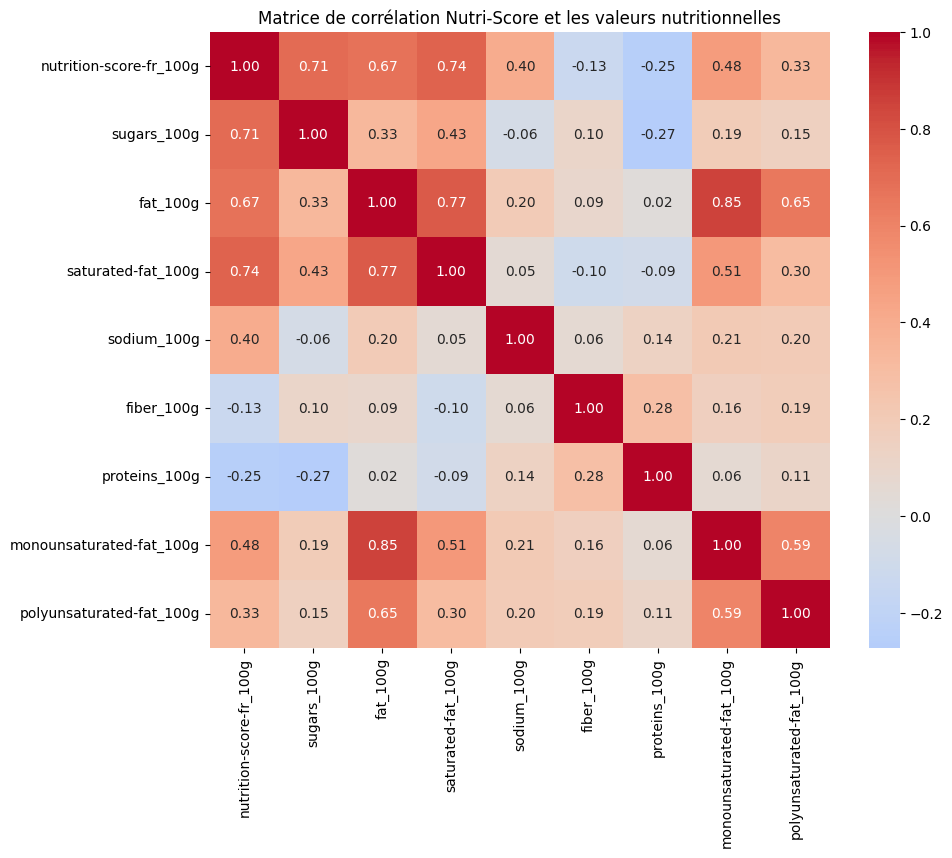

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Matrice de corrélation Nutri-Score et les valeurs nutritionnelles")
plt.show()

In [14]:
#Creation d'un tableau avec les données pertinantes
df_product_categories_whithout_Nan = df_aliment_saint_full[['product_name', 'nutrition-score-fr_100g','nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'additives_n', 'ingredients_text']+columns_of_interest]
#retirer les produits qui possède la catégorie "unknown"
df_product_categories_whithout_unknown = df_product_categories_whithout_Nan[(df_product_categories_whithout_Nan['pnns_groups_1'] != 'unknown') & (df_product_categories_whithout_Nan['pnns_groups_2'] != 'unknown')]
 
"""
Remarque : Il y a beaucoup de doublons presents dans les nom des categories d'aliments.

Sugary snacks -> sugary-snacks 
Cereals and potatoes -> cereals-and-potatoes 
Fruits and vegetables -> fruits-and-vegetables
Salty snacks -> salty-snacks   

"""
#fusions des colones doublons ensemble dans ma dataframe 
df_categorie_sans_doublon = df_product_categories_whithout_unknown
df_categorie_sans_doublon['pnns_groups_1'] = df_categorie_sans_doublon['pnns_groups_1'].replace('sugary-snacks','Sugary snacks')
df_categorie_sans_doublon['pnns_groups_1'] = df_categorie_sans_doublon['pnns_groups_1'].replace('cereals-and-potatoes','Cereals and potatoes')
df_categorie_sans_doublon['pnns_groups_1'] = df_categorie_sans_doublon['pnns_groups_1'].replace('fruits-and-vegetables','Fruits and vegetables')
df_categorie_sans_doublon['pnns_groups_1'] = df_categorie_sans_doublon['pnns_groups_1'].replace('salty-snacks','Salty snacks')

#Affichage du nombre d'aliments dans chaques catégorie d'aliments
nombre_aliments_par_categorie = df_categorie_sans_doublon['pnns_groups_1'].value_counts()
nombre_aliments_par_categorie

C:\Users\p2972\AppData\Local\Temp\ipykernel_12596\1420143005.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorie_sans_doublon['pnns_groups_1'] = df_categorie_sans_doublon['pnns_groups_1'].replace('sugary-snacks','Sugary snacks')
C:\Users\p2972\AppData\Local\Temp\ipykernel_12596\1420143005.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorie_sans_doublon['pnns_groups_1'] = df_categorie_sans_doublon['pnns_groups_1'].replace('cereals-and-potatoes','Cereals and potatoes')
C:\Users\p29

pnns_groups_1
Cereals and potatoes       5833
Sugary snacks              5757
Composite foods            5467
Beverages                  5308
Milk and dairy products    4999
Fruits and vegetables      3730
Fish Meat Eggs             3653
Fat and sauces             1801
Salty snacks               1585
Name: count, dtype: int64

In [15]:
#retirer le nan de la colonne pnns_groups_1
df_categorie_sans_doublon = df_categorie_sans_doublon.dropna(subset=['pnns_groups_1'])
# Liste des catégories d'aliments
categories = df_categorie_sans_doublon['pnns_groups_1'].unique().tolist()

#creer un dataframe pour chaques catégorie d'aliments
df_categorie_fruits_and_vegetables = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Fruits and vegetables'].sort_values(by='nutrition-score-fr_100g', ascending=True)
df_categorie_sugary_snacks = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Sugary snacks'].sort_values(by='nutrition-score-fr_100g', ascending=True)
df_categorie_cereals_and_potatoes = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Cereals and potatoes'].sort_values(by='nutrition-score-fr_100g', ascending=True)
df_categorie_salty_snacks = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Salty snacks'].sort_values(by='nutrition-score-fr_100g', ascending=True)
df_categorie_beverages = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Beverages'].sort_values(by='nutrition-score-fr_100g', ascending=True)
df_categorie_fat_and_sauces = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Fat and sauces'].sort_values(by='nutrition-score-fr_100g', ascending=True)
df_categorie_fish_meat_eggs = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Fish Meat Eggs'].sort_values(by='nutrition-score-fr_100g', ascending=True)
df_categorie_milk_and_dairy_products = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Milk and dairy products'].sort_values(by='nutrition-score-fr_100g', ascending=True)
df_categorie_composite_foods = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Composite foods'].sort_values(by='nutrition-score-fr_100g', ascending=True)
sous_cat_df_categorie_fruits_and_vegetables = df_categorie_fruits_and_vegetables['pnns_groups_2'].unique()


In [16]:

#Affichage des 3 aliments les plus sains par catégorie d'aliments
print("les 3 aliments les plus sains par catégorie d'aliments: \n") 
print("Bevarages :")
print(df_categorie_beverages['product_name'].iloc[:3].tolist() , "\n")
print("Fruits and vegetables :")
print(df_categorie_fruits_and_vegetables['product_name'].iloc[:3].tolist() , "\n")
print("Sugary snacks :")
print(df_categorie_sugary_snacks['product_name'].iloc[:3].tolist() , "\n")
print("Cereals and potatoes :")
print(df_categorie_cereals_and_potatoes['product_name'].iloc[:3].tolist() , "\n")
print("Salty snacks :")
print(df_categorie_salty_snacks['product_name'].iloc[:3].tolist() , "\n")
print("Fat and sauces :")
print(df_categorie_fat_and_sauces['product_name'].iloc[:3].tolist() , "\n")
print("Fish Meat Eggs :")
print(df_categorie_fish_meat_eggs['product_name'].iloc[:3].tolist() , "\n")
print("Milk and dairy products :")
print(df_categorie_milk_and_dairy_products['product_name'].iloc[:3].tolist() , "\n")
print("Composite foods :")
print(df_categorie_composite_foods['product_name'].iloc[:3].tolist() , "\n")


# Afficher df avec uniquement les aliments les plus sains par catégorie d'aliments
# Créer une liste des index des aliments les plus sains par catégorie
indices_les_plus_sains = (
    df_categorie_beverages['product_name'].index[:3].tolist()  +
    df_categorie_fruits_and_vegetables['product_name'].index[:3].tolist() +
    df_categorie_sugary_snacks['product_name'].index[:3].tolist() +
    df_categorie_cereals_and_potatoes['product_name'].index[:3].tolist() +
    df_categorie_salty_snacks['product_name'].index[:3].tolist() +
    df_categorie_fat_and_sauces['product_name'].index[:3].tolist() +
    df_categorie_fish_meat_eggs['product_name'].index[:3].tolist() +
    df_categorie_milk_and_dairy_products['product_name'].index[:3].tolist() +
    df_categorie_composite_foods['product_name'].index[:3].tolist()
)

# Filtrer df_aliment_saint en utilisant les indices
df_aliments_les_plus_sain = df_aliment_saint_full.loc[indices_les_plus_sains]





les 3 aliments les plus sains par catégorie d'aliments: 

Bevarages :
['Vegetable juice', 'Safeway apple juice', 'Lord Nelson Kamille Kräutertee'] 

Fruits and vegetables :
['Lentilles corail bio', 'Choux-fleurs en fleurettes', 'Edamamé Beans Nature'] 

Sugary snacks :
['Préparation de fruits Fraise 0 % de sucres ajoutés', 'Les Craquelins de Saint Malo Nature', 'Smart Pancake'] 

Cereals and potatoes :
['Corn on the cob', 'Céréales & Légumes secs - Orge, Épeautre, Lentilles, Pois cassés', 'Haricot Beurre extra-fin'] 

Salty snacks :
["Houmous au sésame et huile d'olive 3,2%", 'Châtaignes entières déjà égouttées', 'Châtaignes'] 

Fat and sauces :
['Purée de Tomates', 'Purée de tomates', 'Tomacouli Basilic'] 

Fish Meat Eggs :
["Filets de colin d'Alaska", 'Cabillaud surgelé, 4 filets ', 'Filets de cabillaud'] 

Milk and dairy products :
['Activia Fibre', 'clinutren', 'QuarkCreme Natur'] 

Composite foods :
['Lentilles Bio', 'Lentilles préparées', 'Haricots Coco cuisinés aux Tomates lauri

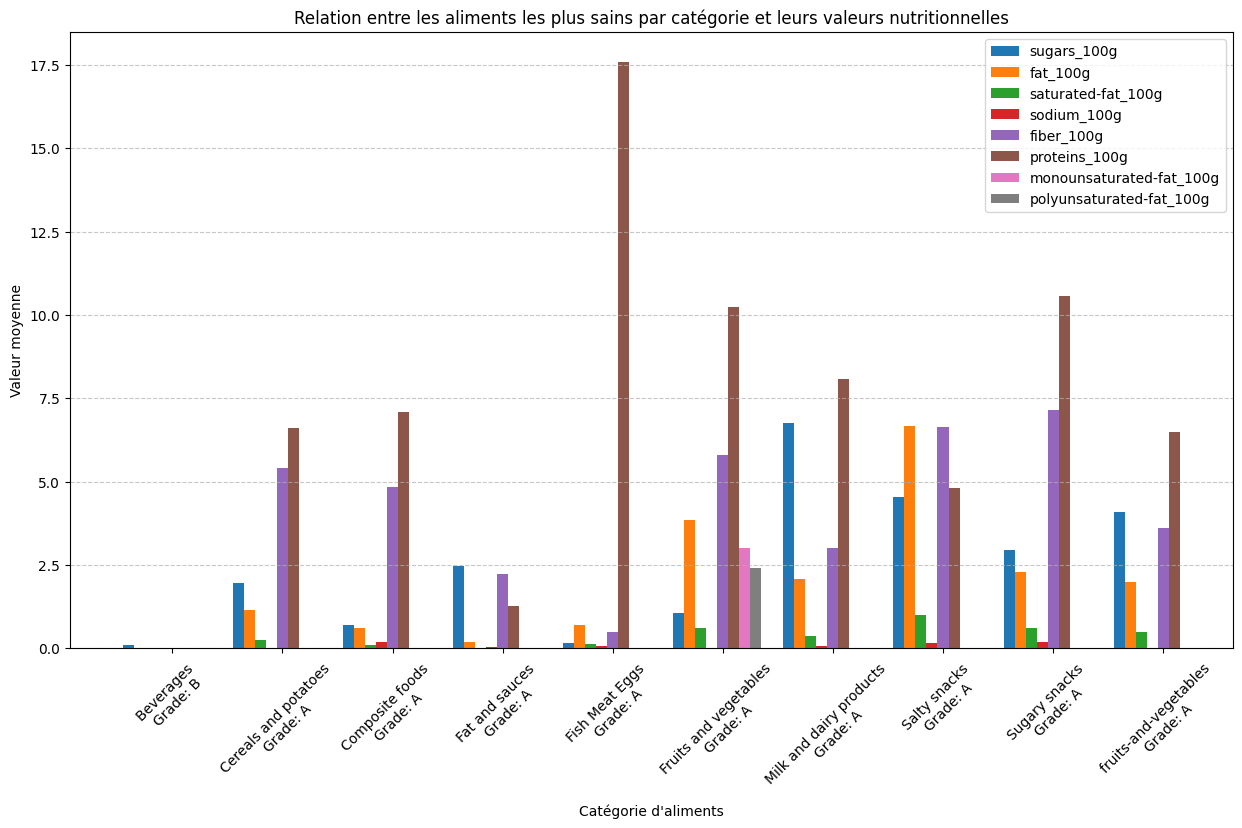

In [17]:
#graphique pour afficher les moyenne de valeurs nutritionnelles par catégorie d'aliments
# Colonnes pertinentes pour l'analyse
columns_of_interest = [
    'sugars_100g', 'fat_100g', 'saturated-fat_100g',
    'sodium_100g', 'fiber_100g', 'proteins_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g'
]
# Calculer les moyennes par catégorie d'aliments
mean_values = df_aliments_les_plus_sain.groupby('pnns_groups_1')[columns_of_interest].mean()

# Calculer le nutrigrade le plus fréquent pour chaque catégorie
most_frequent_nutrigrade = (
    df_aliments_les_plus_sain.groupby('pnns_groups_1')['nutrition_grade_fr']
    .agg(lambda x: x.mode()[0])  # Mode pour trouver la valeur la plus fréquente
)

# Ajouter le nutrigrade dans les labels
categories_with_nutrigrade = [
    f"{category} \nGrade: {most_frequent_nutrigrade[category].upper()}"
    for category in mean_values.index
]

# Paramètres pour le barplot groupé
bar_width = 0.1
x = np.arange(len(mean_values.index))  # Position des catégories sur l'axe X

plt.figure(figsize=(15, 8))

# Tracer les barres pour chaque élément nutritionnel
for i, column in enumerate(columns_of_interest):
    plt.bar(
        x + i * bar_width,
        mean_values[column],
        width=bar_width,
        label=column
    )

# Ajouter des labels et une légende
plt.title('Relation entre les aliments les plus sains par catégorie et leurs valeurs nutritionnelles')
plt.xlabel('Catégorie d\'aliments')
plt.ylabel('Valeur moyenne')
plt.xticks(x + bar_width * (len(columns_of_interest) / 2), categories_with_nutrigrade, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:

#Affichage des 3 aliments les moins sains par catégorie d'aliments

#creer un dataframe pour chaques catégorie d'aliments
df_categorie_fruits_and_vegetables2 = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Fruits and vegetables'].sort_values(by='nutrition-score-fr_100g', ascending=False)
df_categorie_sugary_snacks2 = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Sugary snacks'].sort_values(by='nutrition-score-fr_100g', ascending=False)
df_categorie_cereals_and_potatoes2 = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Cereals and potatoes'].sort_values(by='nutrition-score-fr_100g', ascending=False)
df_categorie_salty_snacks2 = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Salty snacks'].sort_values(by='nutrition-score-fr_100g', ascending=False)
df_categorie_beverages2 = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Beverages'].sort_values(by='nutrition-score-fr_100g', ascending=False)
df_categorie_fat_and_sauces2 = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Fat and sauces'].sort_values(by='nutrition-score-fr_100g', ascending=False)
df_categorie_fish_meat_eggs2 = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Fish Meat Eggs'].sort_values(by='nutrition-score-fr_100g', ascending=False)
df_categorie_milk_and_dairy_products2 = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Milk and dairy products'].sort_values(by='nutrition-score-fr_100g', ascending=False)
df_categorie_composite_foods2 = df_categorie_sans_doublon[df_categorie_sans_doublon['pnns_groups_1'] == 'Composite foods'].sort_values(by='nutrition-score-fr_100g', ascending=False)
sous_cat_df_categorie_fruits_and_vegetables2 = df_categorie_fruits_and_vegetables['pnns_groups_2'].unique()



#Affichage des 3 aliments les moins sains par catégorie d'aliments

print("les 3 aliments les moins sains par catégorie d'aliments: \n")
print("Bevarages :")
print(df_categorie_beverages2['product_name'].iloc[:3].tolist() , "\n")
print("Fruits and vegetables :")
print(df_categorie_fruits_and_vegetables2['product_name'].iloc[:3].tolist() , "\n")
print("Sugary snacks :")
print(df_categorie_sugary_snacks2['product_name'].iloc[:3].tolist() , "\n")
print("Cereals and potatoes :")
print(df_categorie_cereals_and_potatoes2['product_name'].iloc[:3].tolist() , "\n")
print("Salty snacks :")
print(df_categorie_salty_snacks2['product_name'].iloc[:3].tolist() , "\n")
print("Fat and sauces :")
print(df_categorie_fat_and_sauces2['product_name'].iloc[:3].tolist() , "\n")
print("Fish Meat Eggs :")
print(df_categorie_fish_meat_eggs2['product_name'].iloc[:3].tolist() , "\n")
print("Milk and dairy products :")
print(df_categorie_milk_and_dairy_products2['product_name'].iloc[:3].tolist() , "\n")
print("Composite foods :")
print(df_categorie_composite_foods2['product_name'].iloc[:3].tolist() , "\n")


# Afficher df avec uniquement les aliments les moin sains par catégorie d'aliments
# Créer une liste des index des aliments les moin sains par catégorie
indices_les_moins_sains = (
    df_categorie_beverages2['product_name'].index[:3].tolist()  +
    df_categorie_fruits_and_vegetables2['product_name'].index[:3].tolist() +
    df_categorie_sugary_snacks2['product_name'].index[:3].tolist() +
    df_categorie_cereals_and_potatoes2['product_name'].index[:3].tolist() +
    df_categorie_salty_snacks2['product_name'].index[:3].tolist() +
    df_categorie_fat_and_sauces2['product_name'].index[:3].tolist() +
    df_categorie_fish_meat_eggs2['product_name'].index[:3].tolist() +
    df_categorie_milk_and_dairy_products2['product_name'].index[:3].tolist() +
    df_categorie_composite_foods2['product_name'].index[:3].tolist()
)

# Filtrer df_aliment_saint en utilisant les indices
df_aliments_les_moins_sain = df_aliment_saint_full.loc[indices_les_moins_sains]




les 3 aliments les moins sains par catégorie d'aliments: 

Bevarages :
['Cappuccino', 'cappuccino sans sucre ajouté', 'Cappuccino'] 

Fruits and vegetables :
['Bombones rellenos Cereza & Licor', 'Bombones Mon Chéri', 'Cerise à la liqueur'] 

Sugary snacks :
['KitKat', 'KitKat Chunky', 'Sablé au caramel et chocolat au lait'] 

Cereals and potatoes :
['Schoko-Reis', 'Supermi Mi goreng Traditional Instant Noodles', 'Croutons Nature'] 

Salty snacks :
['Les Apérigaufres fourrées saveur Bacon', 'Crêpes dentelle fourrées au cheddar', 'Galichons au cheddar'] 

Fat and sauces :
['The original Hooters Wing sauce - medium', 'Mayonnaise', 'Pesto frais ail des ours'] 

Fish Meat Eggs :
['Lardons fumés', 'Saucisses à cuire fumées', 'Delikatess Teewurst fein'] 

Milk and dairy products :
['Crême de Caramel à la fleur de sel de Guérande', 'Pingui Framboise', '2 Karamell-Schokoladen-Cheesecakes im Glas'] 

Composite foods :
['Club Rosette', 'XXL Rosette de Lyon beurre cornichons', 'Rosette'] 



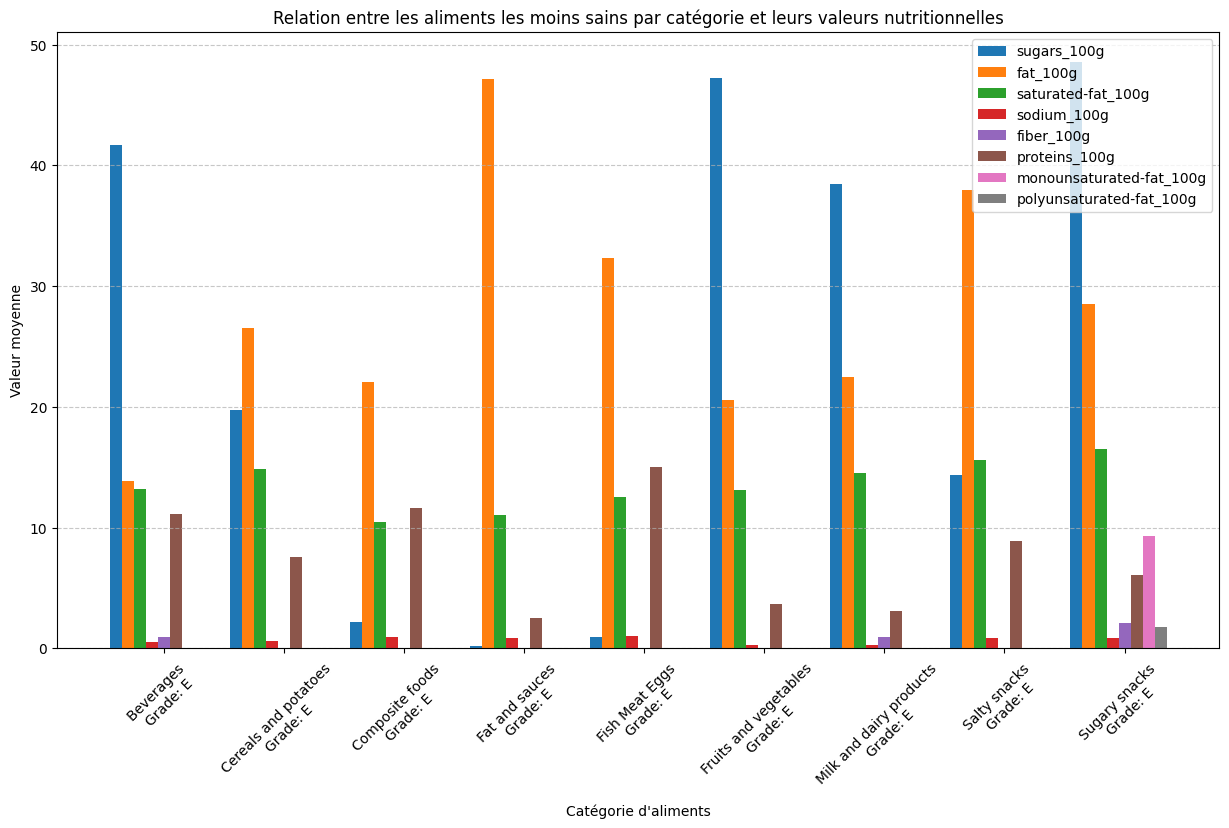

In [19]:
#graphique pour afficher les moyenne de valeurs nutritionnelles par catégorie d'aliments
# Colonnes pertinentes pour l'analyse
columns_of_interest = [
    'sugars_100g', 'fat_100g', 'saturated-fat_100g',
    'sodium_100g', 'fiber_100g', 'proteins_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g'
]
# Calculer les moyennes par catégorie d'aliments
mean_values = df_aliments_les_moins_sain.groupby('pnns_groups_1')[columns_of_interest].mean()

# Calculer le nutrigrade le plus fréquent pour chaque catégorie
most_frequent_nutrigrade = (
    df_aliments_les_moins_sain.groupby('pnns_groups_1')['nutrition_grade_fr']
    .agg(lambda x: x.mode()[0])  # Mode pour trouver la valeur la plus fréquente
)

# Ajouter le nutrigrade dans les labels
categories_with_nutrigrade = [
    f"{category} \nGrade: {most_frequent_nutrigrade[category].upper()}"
    for category in mean_values.index
]

# Paramètres pour le barplot groupé
bar_width = 0.1
x = np.arange(len(mean_values.index))  # Position des catégories sur l'axe X

plt.figure(figsize=(15, 8))

# Tracer les barres pour chaque élément nutritionnel
for i, column in enumerate(columns_of_interest):
    plt.bar(
        x + i * bar_width,
        mean_values[column],
        width=bar_width,
        label=column
    )

# Ajouter des labels et une légende
plt.title('Relation entre les aliments les moins sains par catégorie et leurs valeurs nutritionnelles')
plt.xlabel('Catégorie d\'aliments')
plt.ylabel('Valeur moyenne')
plt.xticks(x + bar_width * (len(columns_of_interest) / 2), categories_with_nutrigrade, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
df_sans_nan['creator'].unique().tolist()

['usda-ndb-import',
 'tacinte',
 'b7',
 'kiliweb',
 'twoflower',
 'andre',
 'tacite',
 'jeanbono',
 'beniben',
 'openfoodfacts-contributors',
 'malikele',
 'teolemon',
 'gildubs',
 'date-limite-app',
 'chandon',
 'kyzh',
 'jm0804',
 'stephane',
 'bdwyer',
 'bcatelin',
 'kp757',
 'recipekeepapp',
 'aeon',
 'manuc66',
 'xmunoz',
 'roblaw',
 'amaurea',
 'svendowideit',
 'agamitsudo',
 'kaman',
 'foodorigins',
 'bori',
 'jolg42',
 'chiefofgxbxl',
 'xiaoma',
 'thibaut75011',
 'sebonlavie',
 'chivos',
 'ghulak75',
 'miles67off',
 'domdom26',
 'zoneblockscommunity',
 'brent',
 'lechatpito',
 'peterbeard',
 'pitajay',
 'smias',
 'big-brother',
 'jibec',
 'clemence',
 'domieg33650',
 'anticultist',
 'agat83',
 'gall',
 'colaboremos',
 'toni',
 'aaronasachimp',
 'ppoppy',
 'pasteis-de-nata',
 'drunkenbison',
 'max4food',
 'sebleouf',
 'kipaul666',
 'chatainsim',
 'koa',
 'rdunant',
 'freedomfood',
 'loupiludo',
 'raphael0202',
 'openfood-ch-import',
 'javichu',
 'kakao',
 'jordan',
 'tulipe',
 '

In [21]:
df_sans_nan['creator'].mode()
#le pays le plus contributeur a openfoodfact sont les etats unis.
#U.S. Department of Agriculture qui entre le plus de produits

0    usda-ndb-import
Name: creator, dtype: object